# White Data - YEOH model

## Required Imports & Function Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import exp

# Setup the plot environment
# ------- my personal graphing style --------------------
plt.style.use('ggplot')
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width   = 8.                        # Width in inches
fig_height  = 1.1*fig_width*golden_mean # Height in inches
fig_size    = [fig_width,fig_height]    # Figure size

params = {'backend': 'pdf',
          'legend.fontsize': 14,
          'xtick.labelsize' : 14,
          'ytick.labelsize' : 14,
          'axes.labelsize' : 16,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

rc("font", **{"size": 10, "family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
# -------------------------------------------------------

## Custom functions

In [2]:
def down_sample(data, n_samples):
    """
    Down sample high frequency data for plotting purposes
        by simply only taking every n points and discarding all inbetween
        this is not a very robust stratergy but for simply plotting visualistion
        purposes it should be fine.
    Args:
        data: The data to be down sampled.
        n_samples: The number of samples that should be in the downsampled dataset.

    Returns:
        dwn_sampled_data: An np array of the down sampled data.   
    """

    dwn_sampled_data = []
    mod = int(len(data)/n_samples)
    for i, e in enumerate(data):
        if i%mod ==0:
            dwn_sampled_data.append(e)

    dwn_sampled_data = np.array(dwn_sampled_data)
    return dwn_sampled_data

def get_yeoh_constants_true(t_stress, t_strain):
    """
    Function which takes in the stress strain data from a test and returns the
        yeoh model constants C10, C20, C30.
        
    This is done using a least squares fit to the model.
        
    Args:
        stress: The stress data.
        strain: The strain data.
        
    Returns:
        constants: The Yeoh model constants [C10, C20, C30].
        sum_residual_sqr: Sums of squared residuals. 
            See https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html for more information.
        """
        
    Q = lambda lam: ((lam*lam) - (1/lam))
    P = lambda lam: ((lam*lam) + (2/lam) - 3)

    percent = 100

    stress_nd = np.zeros((t_stress.shape[0], 1))
    for i, s in enumerate(t_stress):
        stress_nd[i][0] = s

    C10_lst = np.empty([t_stress.shape[0], 1])
    C20_lst = np.empty([t_stress.shape[0], 1])
    C30_lst = np.empty([t_stress.shape[0], 1])

    for i, s in enumerate(t_strain):
        lam = exp(s)
        C10_lst[i][0] = (2*Q(lam))
        C20_lst[i][0] = (4*Q(lam)*P(lam))
        C30_lst[i][0] = (4*Q(lam)*(P(lam)**2))

    # Create A matrix from the above three np.arrays
    A = np.hstack((C10_lst, C20_lst, C30_lst))

    # solve the constants
    constants, sum_residual_sqr, _, _ = np.linalg.lstsq(A, stress_nd, rcond=None)

    return constants, sum_residual_sqr

def yeoh(constants, percent_elongation):
    """
    This is the Yeoh material model function for engineering stress and strain.
        
    Args:
        constants: The Yeoh material model constants C10, C20, C30
        percent_elongation: The strain value of interest in percentage.

    Returns:
        stress: The stress at the provided strain point of interest.
    """

    Q = lambda lam: ((lam*lam) - (1/lam))
    P = lambda lam: ((lam*lam) + (2/lam) - 3)

    lam = ((percent_elongation/100) + 1)

    C10 = constants[0]
    C20 = constants[1]
    C30 = constants[2]

    stress = C10*(2*Q(lam)) + C20*(4*Q(lam)*P(lam)) + C30*(4*Q(lam)*(P(lam)**2))

    return stress

def yeoh_t(t_constants, t_strain):
    """
    This is the Yeoh material model function for true stress and strain.
        
    Args:
        constants: The Yeoh material model constants C10, C20, C30
        percent_elongation: The strain value of interest in true strain.

    Returns:
        stress: The stress at the provided strain point of interest.
    """

    Q = lambda lam: ((lam*lam) - (1/lam))
    P = lambda lam: ((lam*lam) + (2/lam) - 3)

    lam = exp(t_strain)

    C10 = t_constants[0]
    C20 = t_constants[1]
    C30 = t_constants[2]

    return C10*(2*Q(lam)) + C20*(4*Q(lam)*P(lam)) + C30*(4*Q(lam)*(P(lam)**2))

def rms(x, xhat):
    """Calculation of RMS for given inputs."""

    error = 0
    for i in range(len(x)):
        error += (x[i] - xhat[i]) ** 2
    RMS = np.sqrt(error / len(x))
    return RMS

def get_true_stress_strain(strain, stress):
    """
    Converts engineering stress and strain to true stress and strain.
    
    It is not clear if this following equations are also valid for hyperelastic materitals.
    
    Args:
        strain: The engineering strain data points.
        stress: The engineering stress data points.

    Returns:
        true_strain: The converted true strain.
        true_stress: The converted ture stress.
    """
    
    true_stress = [j * (1+(i/100)) for i, j in zip(strain, stress)] # 100 for % elngation to strain conversion
    true_strain = [np.log(1 + (i/100)) for i in strain] # 100 for % elngation to strain conversion

    true_stress = np.array(true_stress)
    true_strain = np.array(true_strain)

    return true_strain, true_stress

def get_normal_stress_strain(t_strain, t_stress):
    """
    Converts ture stress and strain to engineering stress and strain.
    
    It is not clear if this following equations are also valid for hyperelastic materitals.
    
    Args:
        t_strain: The true strain data points.
        t_stress: The true stress data points.

    Returns:
        np_strain: The converted engineering strain as numpy array.
        np_strain: The converted engineering stress as numpy array.
    """
    strain = [exp(ts) - 1 for ts in t_strain]
    stress = [(ts/(1+s)) for ts, s in zip(t_stress, strain)]

    np_strain = np.array(strain)
    np_stress = np.array(stress)
    return np_strain, np_stress


# Placing the .csv into an pandas dataframe

#### The data is in the format
###### Data Point - Time - Displacement - Force - Tensile Stress - Tensile Strain (Extensometer)

In [3]:
fname1 = "example_test_data.csv"
df_1 = pd.read_csv(fname1, header=None)
df_1.columns = ["Data Point", "Time", "Displacement", "Force", "Tensile stress", "Tensile strain (Exten)"]

# Displaying the dataframe
df_1

,Data Point,Time,Displacement,Force,Tensile stress,Tensile strain (Exten)
0,1,0.00,0.0000,-0.0001,-0.0069,0.0061
1,2,0.02,0.0000,0.0000,-0.0004,0.0057
2,3,0.04,0.0013,0.0001,0.0063,0.0008
3,4,0.06,0.0076,0.0001,0.0069,-0.0022
4,5,0.08,0.0207,0.0000,0.0025,0.0055
...,...,...,...,...,...,...
11856,11857,237.12,197.5547,0.0716,7.1594,523.5673
11857,11858,237.14,197.5715,0.0716,7.1596,523.5968
11858,11859,237.16,197.5883,0.0714,7.1441,523.6274
11859,11860,237.18,197.6051,0.0715,7.1504,523.6608


# Creating np arrays for for stress and strain (float format)

In [4]:
stress_1 = df_1['Tensile stress'].to_numpy(dtype=float)
strain_1 = df_1['Tensile strain (Exten)'].to_numpy(dtype=float)

# Plotting the data

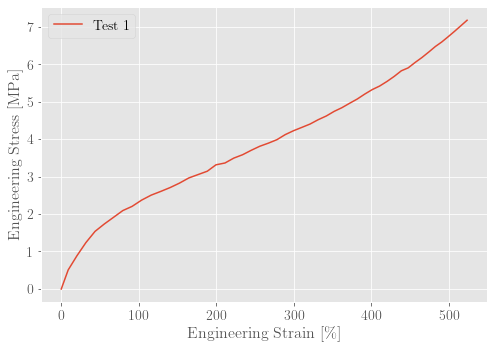

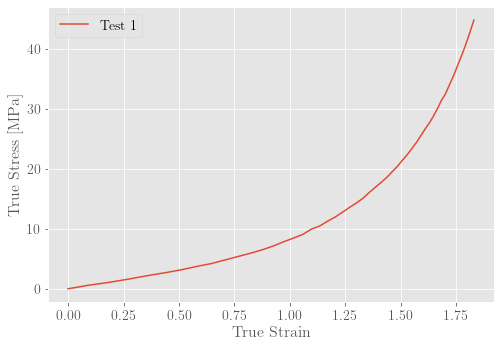

In [5]:
# down sampling the strain values
dwn_smple_data_points = 50
strain_1_dwn_smple = down_sample(strain_1, dwn_smple_data_points)

# down sampling the stress values
stress_1_dwn_smple = down_sample(stress_1, dwn_smple_data_points)

# Converting to true stress and strain DOWN SAMPLED DATA SET
t_strain_1 , t_stress_1 = get_true_stress_strain(strain_1_dwn_smple , stress_1_dwn_smple)

# Converting to true stress and strain COMPLETE DATA SET
t_strain_1_long , t_stress_1_long = get_true_stress_strain(strain_1, stress_1)

# Plotting Engineering stress and strain
plt.plot(strain_1_dwn_smple, stress_1_dwn_smple, '-', label="Test 1")

plt.legend()
plt.xlabel("Engineering Strain [\%]")
plt.ylabel("Engineering Stress [MPa]")
plt.show()

# Plotting true stress and strain
plt.plot(t_strain_1, t_stress_1, '-', label="Test 1")
plt.legend()
plt.xlabel("True Strain")
plt.ylabel("True Stress [MPa]")
plt.show()

## Getting the constants for each test

In [6]:
yeoh_1_t, sum_residual_sqr_1_t = get_yeoh_constants_true(t_stress_1, t_strain_1)

print(f"Yeoh Constants Model 1: {yeoh_1_t.T}")

Yeoh Constants Model 1: [[ 6.16373665e-01 -4.14452355e-03  1.01696775e-04]]


## Plotting the model generated from each test
## True Stress and Strain

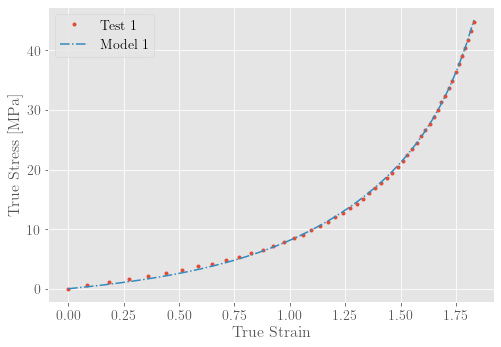

In [7]:
strain_domain_true = np.linspace(0, t_strain_1[-1], dwn_smple_data_points) # choose same number of data points and downsampled data

# create model true stress for models
yeoh_model_stress_1_t = [yeoh_t(yeoh_1_t, i) for i in strain_domain_true]

plt.plot(t_strain_1, t_stress_1, '.', label="Test 1")

plt.plot(strain_domain_true, yeoh_model_stress_1_t, '-.', label="Model 1")

plt.ylabel("True Stress [MPa]")
plt.xlabel("True Strain")
plt.legend()
plt.show()

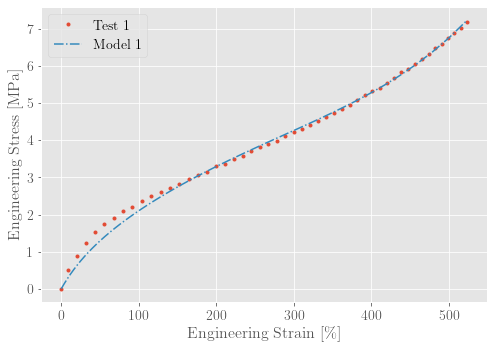

In [8]:

back_convert_eng_strain_1, back_convert_eng_stress_1 = get_normal_stress_strain(strain_domain_true, yeoh_model_stress_1_t)

back_convert_eng_test_strain_1, back_convert_eng_test_stress_1 = get_normal_stress_strain(t_strain_1, t_stress_1)

plt.plot(strain_1_dwn_smple, stress_1_dwn_smple, '.', label="Test 1", linewidth='2')
plt.plot(back_convert_eng_strain_1*100, back_convert_eng_stress_1, '-.', label="Model 1") # 100 added to convert to percent elongation

plt.legend()
plt.xlabel("Engineering Strain [\%]")
plt.ylabel("Engineering Stress [MPa]")
plt.show()
